# Building and training AlexNet

## Import Libraries

In [1]:
import torch
import torchvision.transforms.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms


## Creating dataloaders for AlexNet by spliting dataset into train and test sets

In [2]:
# Define transforms for the dataset
transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor()])

# Load the dataset
traindata = ImageFolder(root='./cnn_dataset', transform=None)

# Compute the mean and standard deviation values for your dataset
mean = torch.zeros(3)
std = torch.zeros(3)
for img, _ in traindata:
    img = F.to_tensor(img)
    mean += img.mean(dim=(1, 2))
    std += img.std(dim=(1, 2))

mean /= len(traindata)
std /= len(traindata)

print(mean)
print(std)

# Normalize the dataset
normalize = transforms.Normalize(mean=mean, std=std)
traindata = ImageFolder(root='./cnn_dataset', transform=transforms.Compose([
    transform,
    normalize,
]))

# Split the dataset into train and validation sets
trainsize = int(0.8 * len(traindata))
testsize = len(traindata) - trainsize
traindata, testdata = torch.utils.data.random_split(traindata, [trainsize, testsize])

# Create dataloaders
train_loader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)


tensor([0.5047, 0.4501, 0.3840])
tensor([0.2386, 0.2384, 0.2404])


## Visualizations of dataset to better understand the dataset: <BR>
### Sample images from each class in dataset:

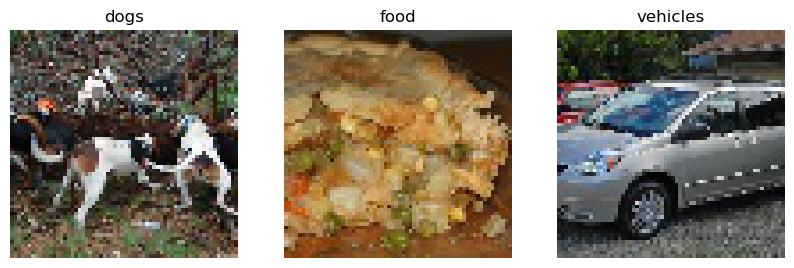

In [61]:
import matplotlib.pyplot as plt
import os
import random

data_dir = 'cnn_dataset'
classes = os.listdir(data_dir)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
for i in range(len(classes)):
    cls = classes[i]
    img_path = os.path.join(data_dir, cls, random.choice(os.listdir(os.path.join(data_dir, cls))))
    img = plt.imread(img_path)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(cls)

plt.show()


### Class Distribution ( number of images in each class )

C:\Users\29vai\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


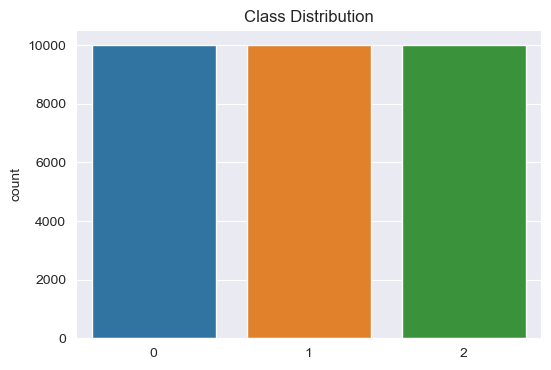

In [63]:
import seaborn as sns

# Get class distribution
class_dist = traindata.dataset.targets
sns.set_style('darkgrid')
plt.figure(figsize=(6, 4))
sns.countplot(class_dist)
plt.title('Class Distribution')
plt.show()



### Sample pixel intensity distribution of an image:

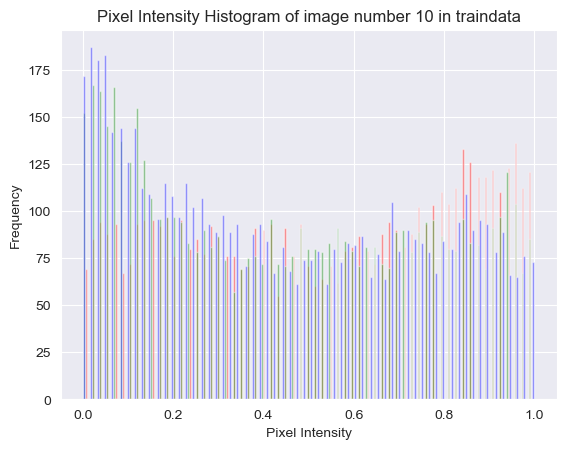

In [66]:
# Choose an image from the training dataset
img, _ = traindata[10]

# Plot a histogram of the pixel intensities for the red channel
plt.hist(img[0].flatten(), bins=256, range=(0, 1), color='red', alpha=0.5)

# Plot a histogram of the pixel intensities for the green channel
plt.hist(img[1].flatten(), bins=256, range=(0, 1), color='green', alpha=0.5)

# Plot a histogram of the pixel intensities for the blue channel
plt.hist(img[2].flatten(), bins=256, range=(0, 1), color='blue', alpha=0.5)

plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Histogram of image number 10 in traindata')
plt.show()

## AlexNet architecture

In [92]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


## Training the AlexNet model

In [93]:
import torch.optim as optim
import time

# Define the model
net = AlexNet(num_classes=3)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print('Device:', device)

num_epochs = 0
train_losses = []
train_accs = []
test_losses = []
test_accs = []
training_time_list = []

while True:
    start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    test_loss = 0.0
    test_correct = 0
    test_total = 0  
    
    num_epochs += 1
       
    # Train the model
    net.train()
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    # Evaluate the model on the testing data
    net.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    epo_time = time.time() - start_time
    # Save the training and test loss and accuracy for this epoch
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_correct / train_total)
    test_losses.append(test_loss / len(test_loader))
    test_accs.append(test_correct / test_total)
    training_time_list.append(epo_time)
    # Print the results for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} -- Training Loss: {train_losses[-1]:.4f}, "
          f"Training Accuracy: {train_accs[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
          f"Test Accuracy: {test_accs[-1]:.4f},  epo_time: {(epo_time/60):.3f} mins")
    
    # Check if the total accuracy is greater than 94%
    if test_accs[-1] > 0.94:
        break


print(f"Model accuracy: {test_accs[-1]:.4f}")
print(f"Total model training time: {sum(training_time_list)/3600} hours")


Device: cpu
Epoch 2/1 -- Training Loss: 1.0901, Training Accuracy: 0.3536, Test Loss: 1.0372, Test Accuracy: 0.3973,  epo_time: 17.559 mins
Epoch 2/2 -- Training Loss: 0.8218, Training Accuracy: 0.6175, Test Loss: 0.7579, Test Accuracy: 0.6583,  epo_time: 14.335 mins
Epoch 2/3 -- Training Loss: 0.6013, Training Accuracy: 0.7404, Test Loss: 0.5253, Test Accuracy: 0.7813,  epo_time: 13.661 mins
Epoch 2/4 -- Training Loss: 0.4416, Training Accuracy: 0.8217, Test Loss: 0.4841, Test Accuracy: 0.8173,  epo_time: 14.653 mins
Epoch 2/5 -- Training Loss: 0.3707, Training Accuracy: 0.8571, Test Loss: 0.3433, Test Accuracy: 0.8728,  epo_time: 16.291 mins
Epoch 2/6 -- Training Loss: 0.3318, Training Accuracy: 0.8746, Test Loss: 0.3068, Test Accuracy: 0.8832,  epo_time: 14.570 mins
Epoch 2/7 -- Training Loss: 0.3175, Training Accuracy: 0.8822, Test Loss: 0.2951, Test Accuracy: 0.8913,  epo_time: 14.303 mins
Epoch 2/8 -- Training Loss: 0.3074, Training Accuracy: 0.8870, Test Loss: 0.3019, Test Accur

### Comparison of Training Accuracy and Test Accuracy and Comparison of Training loss and Testing loss

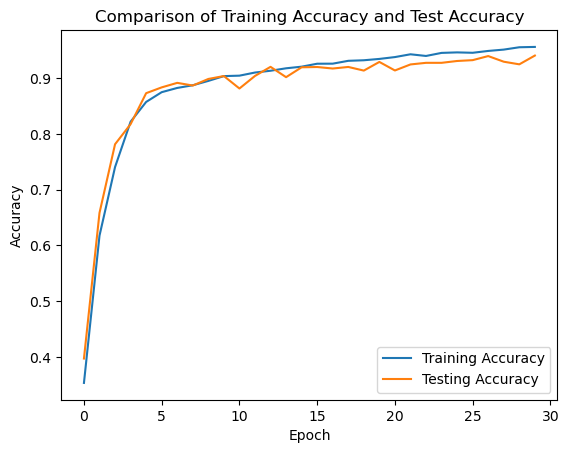

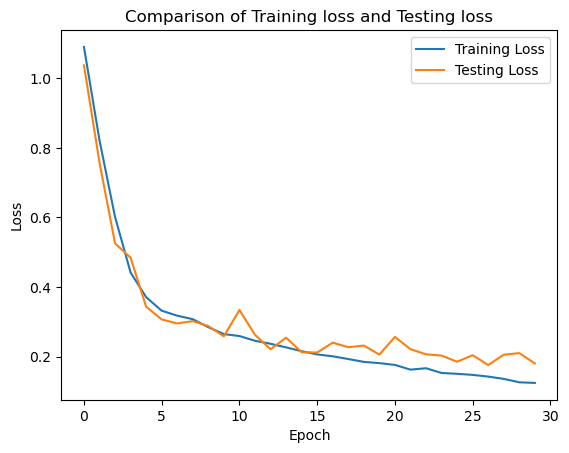

In [2]:
import matplotlib.pyplot as plt

# plot accuracy curves
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparison of Training Accuracy and Test Accuracy')
plt.legend()
plt.show()

# plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Training loss and Testing loss')
plt.legend()
plt.show()

## Modified and Improved AlexNet model

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNetmodified(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetmodified, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64), # add batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192), # add batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384), # add batch normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), # add batch normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), # add batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5), # add dropout
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096), # add batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5), # add dropout
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096), # add batch normalization
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


## Training modified AlexNet model

In [7]:
import torch.optim as optim
import time

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from tqdm import tqdm 

# Define the model
model = AlexNetmodified(num_classes=3)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print('Device:', device)


# define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

# define the number of epochs and early stopping criteria
patience = 30
best_loss = float('inf')
counter = 0
num_epochs= 0

updated_train_losses = []
updated_train_accs = []
updated_test_losses = []
updated_test_accs = []
updated_training_time_list = []

while True:
    start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    test_loss = 0.0
    test_correct = 0
    test_total = 0  
    
        
    num_epochs += 1
    
    # Train the model
    model.train()
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    # Evaluate the model on the testing set
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
    epo_time = time.time() - start_time
    # Save the training and test loss and accuracy for this epoch
    updated_train_losses.append(train_loss / len(train_loader))
    updated_train_accs.append(train_correct / train_total)
    updated_test_losses.append(test_loss / len(test_loader))
    updated_test_accs.append(test_correct / test_total)
    updated_training_time_list.append(epo_time)
    # Print the results for this epoch
    print(f"Epoch {num_epochs+1} -- Training Loss: {updated_train_losses[-1]:.4f}, "
          f"Training Accuracy: {updated_train_accs[-1]:.4f}, Test Loss: {updated_test_losses[-1]:.4f}, "
          f"Test Accuracy: {updated_test_accs[-1]:.4f},  epo_time: {(epo_time/60):.3f} mins")
    # check if loss has improved
    
    if train_loss < best_loss:
        best_loss = train_loss
        counter = 0
        torch.save(model.state_dict(), 'part3.h')
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping: the model has not improved for {} epochs".format(patience))
        break
    
    # Check if the total accuracy is greater than 94%
    if updated_test_accs[-1] > 0.94:
        break

print(f"Model accuracy: {updated_test_accs[-1]:.4f}")
print(f"Total model training time: {sum(updated_training_time_list)/3600} hours")


Device: cpu
Epoch 2 -- Training Loss: 0.4338, Training Accuracy: 0.8239, Test Loss: 0.6459, Test Accuracy: 0.7538,  epo_time: 18.079 mins
Epoch 2 -- Training Loss: 0.3091, Training Accuracy: 0.8840, Test Loss: 0.2828, Test Accuracy: 0.8928,  epo_time: 14.596 mins
Epoch 2 -- Training Loss: 0.2662, Training Accuracy: 0.9003, Test Loss: 0.3245, Test Accuracy: 0.8808,  epo_time: 14.239 mins
Epoch 2 -- Training Loss: 0.2384, Training Accuracy: 0.9105, Test Loss: 0.4749, Test Accuracy: 0.8142,  epo_time: 14.855 mins
Epoch 2 -- Training Loss: 0.2148, Training Accuracy: 0.9198, Test Loss: 0.3850, Test Accuracy: 0.8607,  epo_time: 14.570 mins
Epoch 2 -- Training Loss: 0.1945, Training Accuracy: 0.9273, Test Loss: 0.2057, Test Accuracy: 0.9262,  epo_time: 14.534 mins
Epoch 2 -- Training Loss: 0.1791, Training Accuracy: 0.9329, Test Loss: 0.1792, Test Accuracy: 0.9343,  epo_time: 15.070 mins
Epoch 2 -- Training Loss: 0.1605, Training Accuracy: 0.9390, Test Loss: 0.2365, Test Accuracy: 0.9140,  ep

## Comparison of Training Accuracy and Test Accuracy and Comparison of Training loss and Testing loss

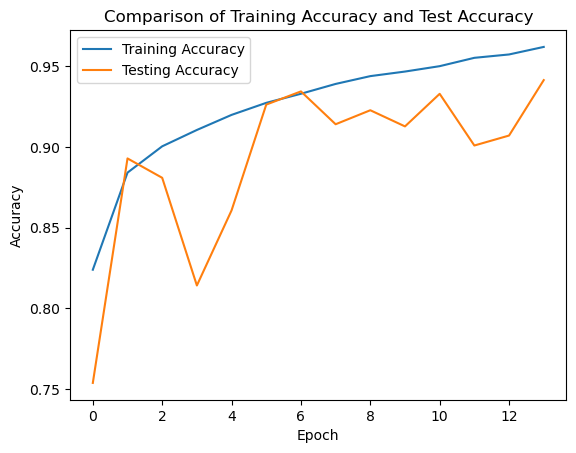

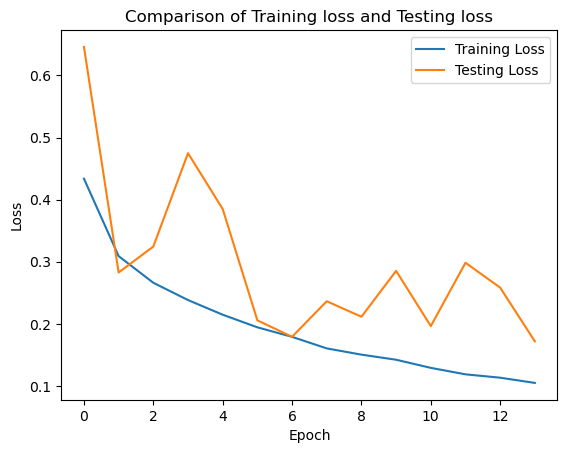

In [21]:
import matplotlib.pyplot as plt

# plot accuracy curves
plt.plot(updated_train_accs, label='Training Accuracy')
plt.plot(updated_test_accs, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparison of Training Accuracy and Test Accuracy')
plt.legend()
plt.show()

# plot loss curves
plt.plot(updated_train_losses, label='Training Loss')
plt.plot(updated_test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Training loss and Testing loss')
plt.legend()
plt.show()

# Optimized AlexNet and Data Argumentation

## Importing libraries

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Spliting dataset into train and test and creating dataloaders to train model

In [2]:
#Transform applied to test
transform_ini= transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Datasets without data augmentation
traindata = torchvision.datasets.SVHN(
    root='./data', 
    split='train', 
    download=True, 
    transform=transform_ini
)

testdata = torchvision.datasets.SVHN(
    root='./data', 
    split='test', 
    download=True, 
    transform=transform_ini
)

# Define transformations to be applied to data
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(15), 
    transforms.RandomCrop(32, padding=4),   
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])


# Load SVHN dataset
trainset_augmented = torchvision.datasets.SVHN(
    root='./data', 
    split='train',
    download=True, 
    transform=transform_train
)

# Concatenate the original dataset with the augmented dataset
traindataset = torch.utils.data.ConcatDataset([traindata, trainset_augmented])
testdataset = testdata

# Create data loaders for the training and test datasets
train_loader1 = torch.utils.data.DataLoader(
    traindataset,
    batch_size=32,
    shuffle=True
)

test_loader1 = torch.utils.data.DataLoader(
    testdataset,
    batch_size=32,
    shuffle=False
)


Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
Using downloaded and verified file: ./data\train_32x32.mat


## Visualization to better understand the dataset<br>
### Visualize 3 random images from training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


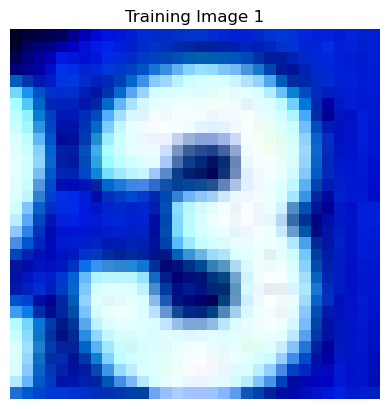

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


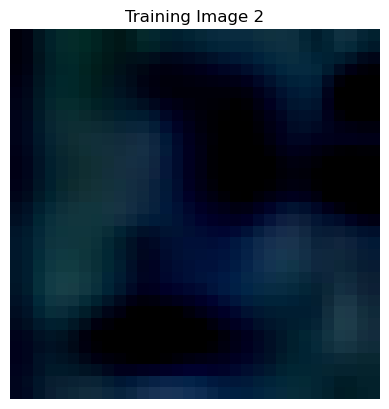

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


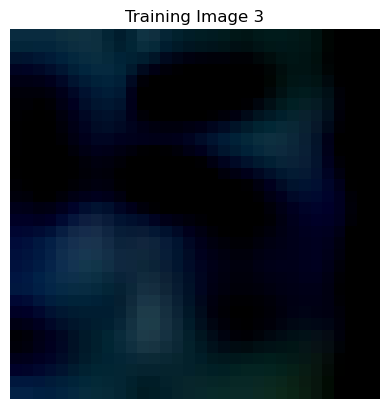

In [43]:
import matplotlib.pyplot as plt

for i in range(3,6):
    img, _ = traindataset[i]
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Training Image {}".format(i-2))
    plt.axis("off")
    plt.show()


### Visualize 3 random images from test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


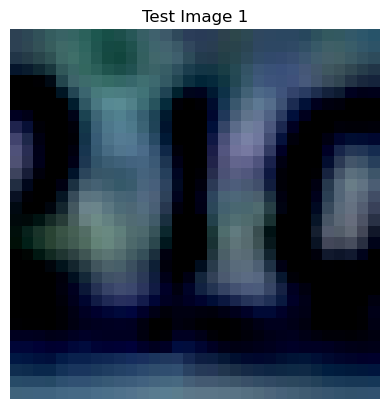

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


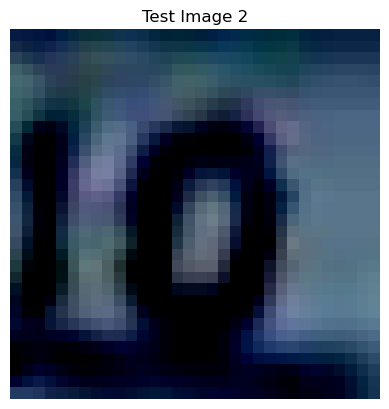

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


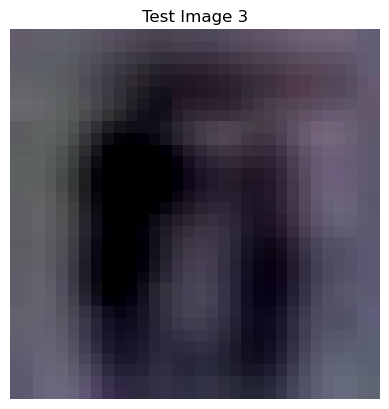

In [45]:
for i in range(2,5):
    img, _ = testdataset[i]
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Test Image {}".format(i-1))
    plt.axis("off")
    plt.show()


### Shape of the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of the tensor: torch.Size([3, 32, 32])


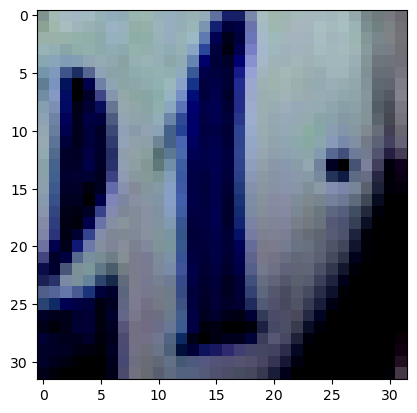

In [49]:
# Get a sample image
sample_img, _ = traindataset[1000]

# Print the shape of the tensor
print(f"Shape of the tensor: {sample_img.shape}")

# Visualize the image
plt.imshow(sample_img.permute(1, 2, 0))
plt.show()

### Sample pixel intensity distribution of an image:

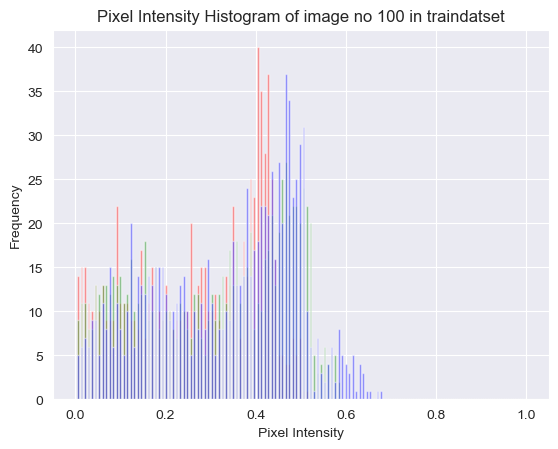

In [67]:
import matplotlib.pyplot as plt

# Choose an image from the training dataset
img, _ = traindataset[100]

# Plot a histogram of the pixel intensities for the red channel
plt.hist(img[0].flatten(), bins=256, range=(0, 1), color='red', alpha=0.5)

# Plot a histogram of the pixel intensities for the green channel
plt.hist(img[1].flatten(), bins=256, range=(0, 1), color='green', alpha=0.5)

# Plot a histogram of the pixel intensities for the blue channel
plt.hist(img[2].flatten(), bins=256, range=(0, 1), color='blue', alpha=0.5)

plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Histogram of image no 100 in traindatset')
plt.show()


## Improved AlexNet CNN architecture from Part III adjusted for SVHN task

In [3]:
class ModifiedModel(nn.Module):
    def __init__(self,num_classes):
        super(ModifiedModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x




## Training model

In [6]:
# Define the model
model1 = ModifiedModel(num_classes=10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

# Train the model
device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device1)
print('Device:', device1)


# define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

# define the number of epochs and early stopping criteria
patience = 30
best_loss = float('inf')
counter = 0
num_epochs=0

svhn_train_losses = []
svhn_train_accs = []
svhn_test_losses = []
svhn_test_accs = []
svhn_training_time_list = []

while True:
    start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    test_loss = 0.0
    test_correct = 0
    test_total = 0 
    
    num_epochs += 1
    
    # Train the model
    model1.train()
    for i, (inputs, labels) in enumerate(train_loader1, 0):
        inputs, labels = inputs.to(device1), labels.to(device1)
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    # Evaluate the model on the testing set
    model1.eval()
    with torch.no_grad():
        for inputs, labels in test_loader1:
            inputs, labels = inputs.to(device1), labels.to(device1)
            outputs = model1(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
    epo_time = time.time() - start_time
    # Save the training and test loss and accuracy for this epoch
    svhn_train_losses.append(train_loss / len(train_loader1))
    svhn_train_accs.append(train_correct / train_total)
    svhn_test_losses.append(test_loss / len(test_loader1))
    svhn_test_accs.append(test_correct / test_total)
    svhn_training_time_list.append(epo_time)
    # Print the results for this epoch
    print(f"Epoch {num_epochs} -- Training Loss: {svhn_train_losses[-1]:.4f}, "
          f"Training Accuracy: {svhn_train_accs[-1]:.4f}, Test Loss: {svhn_test_losses[-1]:.4f}, "
          f"Test Accuracy: {svhn_test_accs[-1]:.4f},  epo_time: {(epo_time/60):.3f} mins")
    # check if loss has improved
    
    if train_loss < best_loss:
        best_loss = train_loss
        counter = 0
        torch.save(model1.state_dict(), 'part4.h')
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping: the model has not improved for {} epochs".format(patience))
        break
        
    # Check if the total accuracy is greater than 80%
    if svhn_test_accs[-1] > 0.80:
        break

print(f"Model accuracy: {svhn_test_accs[-1]:.4f}")
print(f"Total model training time: {sum(svhn_training_time_list)/3600} hours")


Device: cpu
Epoch 1 -- Training Loss: 2.2405, Training Accuracy: 0.1888, Test Loss: 2.2240, Test Accuracy: 0.1959,  epo_time: 30.358 mins
Epoch 2 -- Training Loss: 2.2362, Training Accuracy: 0.1892, Test Loss: 2.2235, Test Accuracy: 0.1959,  epo_time: 28.588 mins
Epoch 3 -- Training Loss: 2.2182, Training Accuracy: 0.1942, Test Loss: 2.0619, Test Accuracy: 0.2545,  epo_time: 28.707 mins
Epoch 4 -- Training Loss: 1.8403, Training Accuracy: 0.3496, Test Loss: 1.1367, Test Accuracy: 0.6380,  epo_time: 28.795 mins
Epoch 5 -- Training Loss: 1.2834, Training Accuracy: 0.5630, Test Loss: 0.5984, Test Accuracy: 0.8256,  epo_time: 28.756 mins
Model accuracy: 0.8256
Total model training time: 2.4200595762994555 hours


### Comparison of Training Accuracy and Test Accuracy and Comparison of Training loss and Testing loss

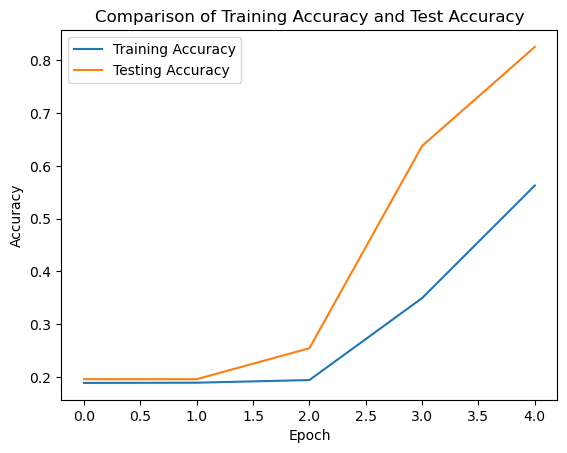

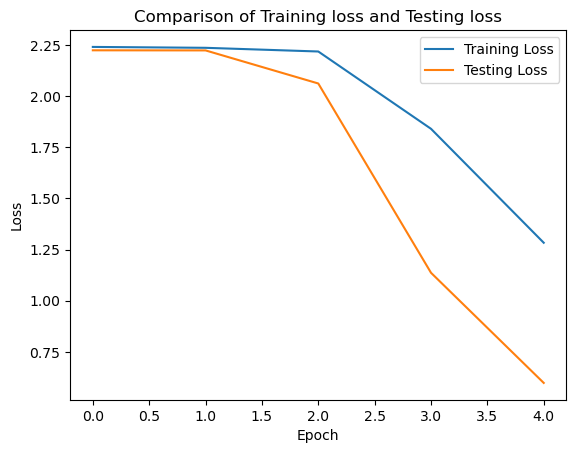

In [7]:
import matplotlib.pyplot as plt

# plot accuracy curves
plt.plot(svhn_train_accs, label='Training Accuracy')
plt.plot(svhn_test_accs, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparison of Training Accuracy and Test Accuracy')
plt.legend()
plt.show()

# plot loss curves
plt.plot(svhn_train_losses, label='Training Loss')
plt.plot(svhn_test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Training loss and Testing loss')
plt.legend()
plt.show()